## Import Libraries & Set columns to "all"

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import math

In [2]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.0f}'.format

## Import Data

In [3]:
melbourne = pd.read_csv('data/melbourne_train_set.csv')

In [4]:
melbourne.head(3)

suburb          address  rooms type  price_$aus method sellerg  \
0  Abbotsford     85 Turner St      2    h     1480000      S  Biggin   
1  Abbotsford  25 Bloomburg St      2    h     1035000      S  Biggin   
2  Abbotsford     5 Charles St      3    h     1465000     SP  Biggin   

         date  distancefromcentre(miles)  postcode  bedroom2  bathroom  car  \
0  2016-12-03                          2      3067         2         1    1   
1  2016-02-04                          2      3067         2         1    0   
2  2017-03-04                          2      3067         3         2    0   

   landsize  buildingarea  yearbuilt councilarea  lat  long  \
0       202           148       1970       Yarra  -38   145   
1       156            79       1900       Yarra  -38   145   
2       134           150       1900       Yarra  -38   145   

              regionname  propertycount    streetname  year     month  \
0  Northern Metropolitan           4019     Turner St  2016  December   
1  Northern Metropolitan           4019  Bloomburg St  2016  February   
2  Northern Metropolitan           4019    Charles St  2017     March   

  builddecade  
0       1970s  
1       1900s  
2       1900s

In [5]:
melbourne = melbourne[melbourne['suburb'].isin(melbourne['suburb'].value_counts()[melbourne['suburb'].value_counts() > 4].index)].reset_index(drop = True)

## Clean & Transform Data

Create a function to change any data types to date, and extract the year, converting it to string. 

In [6]:
def cleaningdata(x):
    
    #transform date column to datetime
    x['date'] = pd.to_datetime(x['date'], format = '%Y-%m-%d')
    
    #change year to string
    x['year'] = x['year'].astype(str)
    x['yearbuilt'] = x['yearbuilt'].astype(str)
    
    
    
    return x

In [7]:
#call function and apply it to df, change price to integer 
mh = cleaningdata(melbourne)
mh['price_$aus'] = mh['price_$aus'].astype(int)

In [8]:
mh.head(5)

suburb           address  rooms type  price_$aus method sellerg  \
0  Abbotsford      85 Turner St      2    h     1480000      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h     1035000      S  Biggin   
2  Abbotsford      5 Charles St      3    h     1465000     SP  Biggin   
3  Abbotsford  40 Federation La      3    h      850000     PI  Biggin   
4  Abbotsford       55a Park St      4    h     1600000     VB  Nelson   

        date  distancefromcentre(miles)  postcode  bedroom2  bathroom  car  \
0 2016-12-03                          2      3067         2         1    1   
1 2016-02-04                          2      3067         2         1    0   
2 2017-03-04                          2      3067         3         2    0   
3 2017-03-04                          2      3067         3         2    1   
4 2016-06-04                          2      3067         3         1    2   

   landsize  buildingarea yearbuilt councilarea  lat  long  \
0       202           148      1970       Yarra  -38   145   
1       156            79      1900       Yarra  -38   145   
2       134           150      1900       Yarra  -38   145   
3        94           148      1970       Yarra  -38   145   
4       120           142      2014       Yarra  -38   145   

              regionname  propertycount     streetname  year     month  \
0  Northern Metropolitan           4019      Turner St  2016  December   
1  Northern Metropolitan           4019   Bloomburg St  2016  February   
2  Northern Metropolitan           4019     Charles St  2017     March   
3  Northern Metropolitan           4019  Federation La  2017     March   
4  Northern Metropolitan           4019        Park St  2016      June   

  builddecade  
0       1970s  
1       1900s  
2       1900s  
3       1970s  
4       2010s

## EDA

### Dealing with Outliers

**We will firstly check for outliers in our price column.**

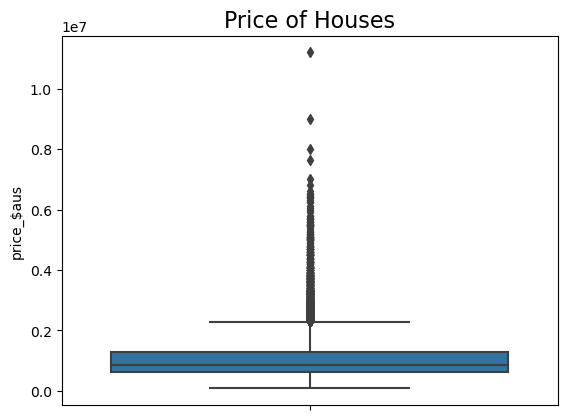

In [9]:
sns.boxplot(y=mh['price_$aus'])
plt.title('Price of Houses', fontsize=16)
plt.show()

*The above boxplot shows some extreme outliers, we will filter them out, as we do not want our model to overfit*

### Finding an appropriate place to filter outliers

In [10]:
#finding our maximum price
mh['price_$aus'].max()

11200000

*The maximum price in our dataset is $11.2 million AUS*

In [11]:
mh_ml = mh[mh['price_$aus'] < 5000000]

As outliers seem to cut off at around AUS$6 million an appropriate place to filter our dataframe is anything between 0 and $5.8 Million AUS

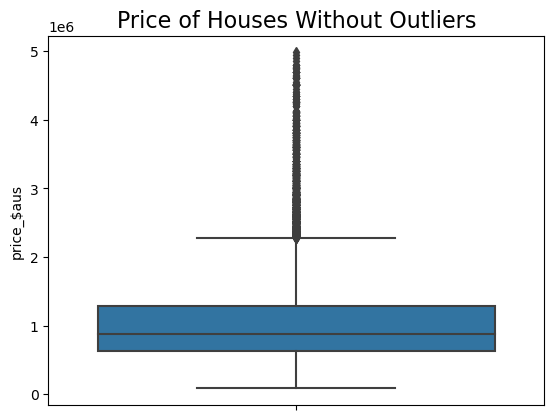

In [12]:
sns.boxplot(y=mh_ml['price_$aus'])
plt.title('Price of Houses Without Outliers', fontsize=16)
plt.show()

## Feature Selection

**We are working with under 30 columns, so we will be hand-picking our features for this model**

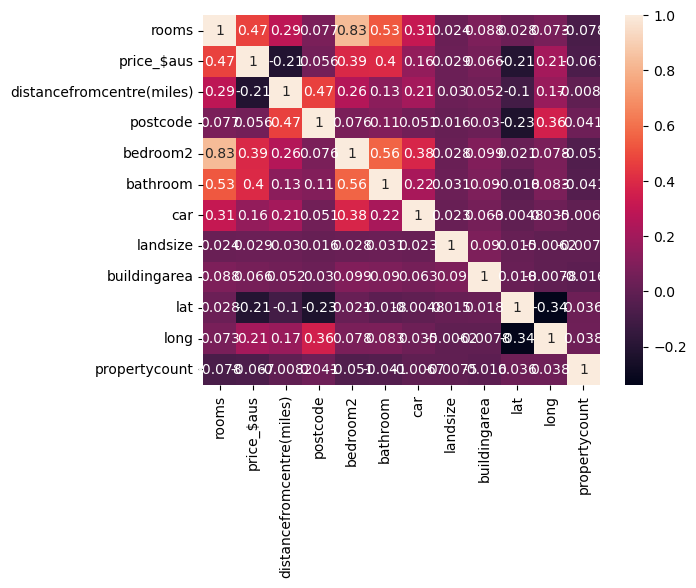

In [13]:
#clearer version of the above
correlations_matrix = mh_ml.select_dtypes(include=np.number).corr()
sns.heatmap(correlations_matrix, annot=True)
plt.show()

The above, while useful to see that there are no immdediate issues with multicolinearity between the features and target, it is quite difficult to see. We will visualise the correlation of columns in a vertical heatmap to more easily distinguish any columns which correlate too strongly with the price. 

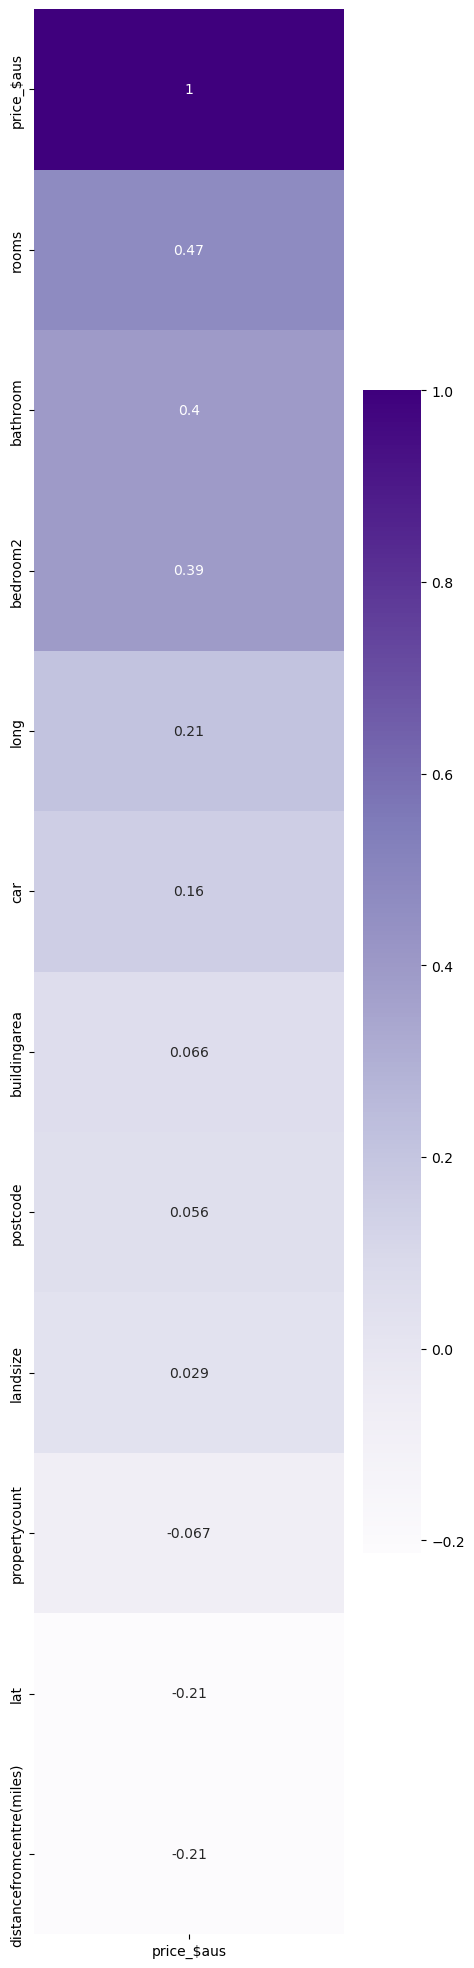

In [14]:
corr = mh_ml.select_dtypes(include=np.number).corr().loc[:,['price_$aus']]
fig, ax = plt.subplots(figsize=(5,25))
ax = sns.heatmap(corr.sort_values(by=['price_$aus'],ascending=False), ax=ax,annot=True,cbar=True,cmap="Purples")
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=10)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=10)
plt.show()

In [15]:
mh_ml.columns

Index(['suburb', 'address', 'rooms', 'type', 'price_$aus', 'method', 'sellerg',
       'date', 'distancefromcentre(miles)', 'postcode', 'bedroom2', 'bathroom',
       'car', 'landsize', 'buildingarea', 'yearbuilt', 'councilarea', 'lat',
       'long', 'regionname', 'propertycount', 'streetname', 'year', 'month',
       'builddecade'],
      dtype='object')

**Now we will choose our features**

In [16]:
mh_ml = mh_ml[['suburb', 'rooms', 'type', 'price_$aus', 'method', 'sellerg', 'distancefromcentre(miles)', 'postcode', 'bedroom2', 'bathroom','car', 'landsize', 'buildingarea', 'builddecade', 'councilarea', 'regionname', 'propertycount', 'year', 'month']]

# Building the model

## Xy Split

In [17]:
y = mh_ml['price_$aus']
X = mh_ml.drop(columns = ["price_$aus"], axis = 1)

## Train Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42) # default split ratio is 80/20

In [19]:
len(X_test)

1355

## Categorical, Numerical Split

In [20]:
#split train data
X_train_numerical =   X_train[['rooms','distancefromcentre(miles)','bedroom2', 'bathroom','car', 'landsize', 'buildingarea']]
X_train_categorical = X_train[['suburb', 'type', 'method', 'postcode', 'builddecade', 'councilarea', 'regionname']]


#split test data
X_test_numerical =   X_test[['rooms','distancefromcentre(miles)','bedroom2', 'bathroom','car', 'landsize', 'buildingarea']]
X_test_categorical = X_test[['suburb', 'type', 'method', 'postcode', 'builddecade', 'councilarea', 'regionname']]

## Dealing with numericals

- **Min-max scaler**
    - squish the data so that the smallest value is 0 and the highest value is 1 (put the data on a scale from 0 to 1)

In [21]:
#Fit ONLY the train set.
MinMaxtransformer = MinMaxScaler().fit(X_train_numerical)

#Train
X_train_normalized = MinMaxtransformer.transform(X_train_numerical)
X_train_minmax = pd.DataFrame(X_train_normalized,columns=X_train_numerical.columns)
#X_train_minmax.head()

#Test
X_test_normalized = MinMaxtransformer.transform(X_test_numerical)
X_test_minmax = pd.DataFrame(X_test_normalized,columns=X_test_numerical.columns)
#X_test_minmax.head()

In [22]:
display(X_train_minmax.head())
display(X_train_minmax.shape)

rooms  distancefromcentre(miles)  bedroom2  bathroom  car  landsize  \
0      0                          0         0         0    0         0   
1      0                          0         0         0    0         0   
2      0                          0         0         0    0         0   
3      0                          0         0         0    0         0   
4      0                          0         0         0    0         0   

   buildingarea  
0             0  
1             0  
2             0  
3             0  
4             0

(25728, 7)

In [23]:
display(X_test_minmax.head())
display(X_test_minmax.shape)

rooms  distancefromcentre(miles)  bedroom2  bathroom  car  landsize  \
0      0                          0         0         0    0         0   
1      0                          0         0         0    0         0   
2      0                          0         0         0    0         0   
3      0                          0         0         0    0         0   
4      0                          0         0         0    0         0   

   buildingarea  
0             0  
1             0  
2             0  
3             0  
4             0

(1355, 7)

## Dealing with categorical data

### OneHot Encoding

In [24]:
#Fit ONLY the train set. 
encoder = OneHotEncoder(drop='first').fit(X_train_categorical)


#Train
encoded_for_p_train = encoder.transform(X_train_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_train_categorical.columns)
X_train_ohe = pd.DataFrame(encoded_for_p_train, columns=cols)
#X_train_ohe.head()


#Test
encoded_for_p_test = encoder.transform(X_test_categorical).toarray()
cols = encoder.get_feature_names_out(input_features=X_test_categorical.columns)
X_test_ohe = pd.DataFrame(encoded_for_p_test, columns=cols)
#X_test_ohe.head()

In [25]:
display(X_train_ohe.head())
display(X_train_ohe.shape)

suburb_Aberfeldie  suburb_Airport west  suburb_Albanvale  \
0                  0                    0                 0   
1                  0                    0                 0   
2                  0                    0                 0   
3                  0                    0                 0   
4                  0                    0                 0   

   suburb_Albert park  suburb_Albion  suburb_Alphington  suburb_Altona  \
0                   0              0                  0              0   
1                   0              0                  0              0   
2                   0              0                  0              0   
3                   0              0                  0              0   
4                   0              0                  0              0   

   suburb_Altona meadows  suburb_Altona north  suburb_Ardeer  suburb_Armadale  \
0                      0                    0              0                0   
1                      0                    0              0                0   
2                      0                    0              0                0   
3                      0                    0              0                0   
4                      0                    0              0                0   

   suburb_Ascot vale  suburb_Ashburton  suburb_Ashwood  suburb_Aspendale  \
0                  0                 0               0                 0   
1                  0                 0               0                 0   
2                  0                 0               0                 0   
3                  0                 0               0                 0   
4                  0                 0               0                 0   

   suburb_Aspendale gardens  suburb_Attwood  suburb_Avondale heights  \
0                         0               0                        0   
1                         0               0                        0   
2                         0               0                        0   
3                         0               0                        0   
4                         0               0                        0   

   suburb_Balaclava  suburb_Balwyn  suburb_Balwyn north  suburb_Bayswater  \
0                 0              0                    0                 0   
1                 0              0                    0                 0   
2                 0              0                    0                 0   
3                 0              0                    0                 0   
4                 0              0                    0                 0   

   suburb_Bayswater north  suburb_Beaumaris  suburb_Bellfield  \
0                       0                 0                 0   
1                       0                 0                 0   
2                       0                 0                 0   
3                       0                 0                 0   
4                       0                 0                 0   

   suburb_Bentleigh  suburb_Bentleigh east  suburb_Berwick  suburb_Black rock  \
0                 0                      0               0                  0   
1                 0                      0               0                  0   
2                 0                      0               0                  0   
3                 0                      0               0                  0   
4                 0                      0               0                  0   

   suburb_Blackburn  suburb_Blackburn north  suburb_Blackburn south  \
0                 0                       0                       0   
1                 0                       0                       0   
2                 0                       0                       0   
3                 0                       0                       0   
4                 0                       0                       0   

   suburb_Bonbeach  suburb_Boronia

(25728, 539)

In [26]:
display(X_test_ohe.head())
display(X_test_ohe.shape)

suburb_Aberfeldie  suburb_Airport west  suburb_Albanvale  \
0                  0                    0                 0   
1                  0                    0                 0   
2                  0                    0                 0   
3                  0                    0                 0   
4                  0                    0                 0   

   suburb_Albert park  suburb_Albion  suburb_Alphington  suburb_Altona  \
0                   0              0                  0              0   
1                   0              0                  0              0   
2                   0              0                  0              0   
3                   0              0                  0              0   
4                   0              0                  0              0   

   suburb_Altona meadows  suburb_Altona north  suburb_Ardeer  suburb_Armadale  \
0                      0                    0              0                0   
1                      0                    0              0                0   
2                      0                    0              0                0   
3                      0                    0              0                0   
4                      0                    0              0                1   

   suburb_Ascot vale  suburb_Ashburton  suburb_Ashwood  suburb_Aspendale  \
0                  0                 0               0                 0   
1                  0                 0               0                 0   
2                  0                 0               0                 0   
3                  0                 0               0                 0   
4                  0                 0               0                 0   

   suburb_Aspendale gardens  suburb_Attwood  suburb_Avondale heights  \
0                         0               0                        0   
1                         0               0                        0   
2                         0               0                        0   
3                         0               0                        0   
4                         0               0                        0   

   suburb_Balaclava  suburb_Balwyn  suburb_Balwyn north  suburb_Bayswater  \
0                 0              0                    0                 0   
1                 0              0                    0                 0   
2                 0              0                    0                 0   
3                 0              0                    0                 0   
4                 0              0                    0                 0   

   suburb_Bayswater north  suburb_Beaumaris  suburb_Bellfield  \
0                       0                 0                 0   
1                       0                 0                 0   
2                       0                 0                 0   
3                       0                 0                 0   
4                       0                 0                 0   

   suburb_Bentleigh  suburb_Bentleigh east  suburb_Berwick  suburb_Black rock  \
0                 0                      0               0                  0   
1                 0                      0               0                  0   
2                 0                      0               0                  0   
3                 0                      0               0                  0   
4                 0                      0               0                  0   

   suburb_Blackburn  suburb_Blackburn north  suburb_Blackburn south  \
0                 0                       0                       0   
1                 0                       0                       0   
2                 0                       0                       0   
3                 0                       0                       0   
4                 0                       0                       0   

   suburb_Bonbeach  suburb_Boronia

(1355, 539)

### Optional : Concatenate categorically encoded dfs
If used both encoding, concatenate the dfs

In [27]:
#Reset Indices in OHE dataframes
X_train_ohe = X_train_ohe.reset_index(drop = True)
X_test_ohe = X_test_ohe.reset_index(drop = True)

## Concatenate categorically_encoded and numerically_scaled dfs

In [28]:
###Reset Indices in scaled dataframes###
X_train_minmax = X_train_minmax.reset_index(drop = True)
X_test_minmax = X_test_minmax.reset_index(drop = True)



#####Concat#####

#Train
X_train_scaled = pd.concat([X_train_minmax,X_train_ohe], axis = 1)

#Test
X_test_scaled = pd.concat([X_test_minmax,X_test_ohe], axis = 1)

## Reset the Incides of our y axes, so that they correspond to the X_train_scaled and X_test_scaled

In [29]:
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

## Fit the Linear regressor

In [30]:
#Define the linear regression model
LR = LinearRegression()

#fit the training set onto the Regressor 
LR.fit(X_train_scaled,y_train)

LinearRegression()

In [31]:
#Predict our y results using our X_test_scaled data, which was based on the rules in our training set. This is also true for the validation set.  
y_pred = LR.predict(X_test_scaled)

In [32]:
#this shows the predicted values of the regression model, based on the features fed into the built model. 
y_pred


print(LR.intercept_) # where the regression line passes the X axis.
#print(LR.coef_) #shows how each feature performed in the model, and its weighting to finding the final decision

3.431636355896738e+16


## Reading the results of our model

In [33]:
train_r2 = LR.score(X_train_scaled, y_train)
test_r2 = LR.score(X_test_scaled, y_test)
print (f'Train R2: {train_r2} \nTest R2: {test_r2}')

Train R2: 0.697996120468485 
Test R2: 0.6903859738799321


The R2 score shows that 69% of the time, our model is quite accurate at predicting the price. However, it is not high enough, and we will test some other regressions to see if they can predict more effectively. 

## Trying different models

### Import ML Models to evaluate

In [34]:
from sklearn.linear_model import LinearRegression as LinReg
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Define a function to evaluate a model's performance

In [35]:
def models_automation(models, X_tr, y_tr, X_te, y_te):
        for model in models:
            model.fit(X_train_scaled,y_train)
            print(f"{model.__class__.__name__}: Train -> {model.score(X_tr, y_tr)}, Test -> {model.score(X_te, y_te)}")

In [36]:
model_list = [LinReg(), SGDRegressor(), KNeighborsRegressor(), MLPRegressor(), DecisionTreeRegressor(), RandomForestRegressor(), HistGradientBoostingRegressor(), GradientBoostingRegressor()]
models_automation(model_list, X_train_scaled, y_train, X_test_scaled, y_test)

LinearRegression: Train -> 0.697996120468485, Test -> 0.6903859738799321
SGDRegressor: Train -> 0.695391445311817, Test -> 0.6895302661243076
KNeighborsRegressor: Train -> 0.7758813025290797, Test -> 0.6611720113413757


/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor: Train -> -1.40090624596283, Test -> -1.3633080159541362
DecisionTreeRegressor: Train -> 0.9788420444630226, Test -> 0.6843759569130198
RandomForestRegressor: Train -> 0.9542526389207857, Test -> 0.8152016444223245
HistGradientBoostingRegressor: Train -> 0.8351007807517193, Test -> 0.8199747509336088
GradientBoostingRegressor: Train -> 0.763090611726044, Test -> 0.7795363550951802


**Here we can see that multiple models seem to do a relatively good job at predicting our house prices. The only problem is getting a more stable R2 score when comparing the models. I therefore decided to employ a voting regressor to be able to more accurately predict the prices, using the strongest-performing models.**

In [37]:
from sklearn.ensemble import VotingRegressor

reg1 = HistGradientBoostingRegressor()
reg2 = RandomForestRegressor()
reg3 = GradientBoostingRegressor()
ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2),('hgb', reg3)])
ereg = ereg.fit(X_train_scaled, y_train)

print("Train R2",ereg.score(X_train_scaled, y_train))
print("Test R2",ereg.score(X_test_scaled, y_test))

Train R2 0.8776903227025534
Test R2 0.8237391243638366


In [38]:
train_mse=mean_squared_error(ereg.predict(X_train_scaled), y_train)
test_mse=mean_squared_error(ereg.predict(X_test_scaled), y_test)
print(f'Train MSE: {train_mse} \nTest MSE: {test_mse}')

Train MSE: 43827976042.71665 
Test MSE: 67499842743.94209


In [39]:
rmse = np.sqrt(test_mse)
rmse

259807.31849573078

**Our R2 score is much higher with our voting regressor, and the Root Mean Squared Error is low enough to be able to use with houses, where it has a margin of error of around AUS 250000  . We will now predict the prices for the NaN values from the original data set.**

### Assign prices to our validation set

In [40]:
#Import data
mel = pd.read_csv('data/melbourne_validation_set.csv')

### Drop the target column (we will be predicting these values) and other unique values unable to process in the model.

In [41]:
mel = mel.drop(columns='price_$aus')

droplist = ['Warranwood', 'Cranbourne north', 'Beaconsfield', 'Clyde north', 'Guys hill', 'Emerald', 'Wonga park', 'Rockbank', 'Lysterfield', 'Avonsleigh', 'Sandhurst', 'Riddells creek', 'Montrose', 'Officer', 'Menzies creek', 'Belgrave', 'Waterways', 'Hopetoun park', 'Darley', 'The basin', 'Olinda', 'Tecoma']
droplistmeth = ['SS', 'W', 'SN', 'PN']

def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

mel = filter_rows_by_values(mel, 'suburb', droplist)
mel = filter_rows_by_values(mel, 'method', droplistmeth)

mel.reset_index(drop = True)

suburb              address  rooms type method        sellerg  \
0         Abbotsford   18/659 Victoria St      3    u     VB         Rounds   
1         Abbotsford         53 Turner St      2    h      S         Biggin   
2         Abbotsford         99 Turner St      2    h      S        Collins   
3         Abbotsford  121/56 Nicholson St      2    u     PI         Biggin   
4         Abbotsford            2 Rich St      2    h     SP         Biggin   
...              ...                  ...    ...  ...    ...            ...   
5751   Vermont south     28 Tullimbar Cct      3    h      S         Jellis   
5752        Werribee         160 Shaws Rd      2    h     PI            YPA   
5753  West melbourne     9/11 Anderson St      3    u      S  hockingstuart   
5754   Wheelers hill           20 Mill Ct      3    h      S          Barry   
5755         Wollert     15 Rockgarden Wy      3    h     SP             LJ   

            date  distancefromcentre(miles)  postcode  bedroom2  bathroom  \
0     2016-02-04                          2      3067         3         2   
1     2016-08-06                          2      3067         4         1   
2     2016-08-06                          2      3067         3         2   
3     2016-11-07                          2      3067         2         2   
4     2016-12-10                          2      3067         2         1   
...          ...                        ...       ...       ...       ...   
5751  2018-02-24                         17      3133         3         2   
5752  2018-02-24                         15      3030         2         1   
5753  2018-02-24                          3      3003         3         1   
5754  2018-02-24                         17      3150         3         2   
5755  2018-02-24                         26      3750         3         2   

      car  landsize  buildingarea  yearbuilt councilarea  lat  long  \
0       1         0           148       1970       Yarra  -38   145   
1       2       201           148       1900       Yarra  -38   145   
2       1       202           148       1900       Yarra  -38   145   
3       1      4292            82       2009       Yarra  -38   145   
4       1       176            80       1925       Yarra  -38   145   
...   ...       ...           ...        ...         ...  ...   ...   
5751    2       655           148       1970  Whitehorse  -38   145   
5752    1       796            98       1975     Wyndham  -38   145   
5753    2       557           148       1970   Melbourne  -38   145   
5754    2       677           148       1970      Monash  -38   145   
5755    2       268           135       2016  Whittlesea  -38   145   

                      regionname  propertycount     streetname  year  \
0          Northern Metropolitan           4019    Victoria St  2016   
1          Northern Metropolitan           4019      Turner St  2016   
2          Northern Metropolitan           4019      Turner St  2016   
3          Northern Metropolitan           4019   Nicholson St  2016   
4          Northern Metropolitan           4019        Rich St  2016   
...                          ...            ...            ...   ...   
5751        Eastern Metropolitan           4280  Tullimbar Cct  2018   
5752        Western Metropolitan          16166       Shaws Rd  2018   
5753       Northern Metropolitan           2230    Anderson St  2018   
5754  South-Eastern Metropolitan           7392        Mill Ct  2018   
5755       Northern Metropolitan           2940  Rockgarden Wy  2018   

         month builddecade  
0     February       1970s  
1       August       1900s  
2       August       1900s  
3     November       2000s  
4     December       1920s  
...        ...         ...  
5751  February       1970s  
5752  February       1970s  
5753  February       1970s  
5754  February       1970s  
5755  February       2010s  

[5756 rows x 24 columns]

### Clean data and transform in preparation for our model.

In [42]:
mh_v = cleaningdata(mel)
mel_v = cleaningdata(mel)


mh_v = mh_v[['suburb', 'rooms', 'type', 'method', 'sellerg', 'distancefromcentre(miles)', 'postcode', 'bedroom2', 'bathroom','car', 'landsize', 'buildingarea', 'builddecade', 'councilarea', 'regionname', 'propertycount', 'year', 'month']]



###Xy Split###

X_v = mh_v

###Cat/Num Split###

X_v_numerical =   X_v[['rooms','distancefromcentre(miles)','bedroom2', 'bathroom','car', 'landsize', 'buildingarea']]
X_v_categorical = X_v[['suburb', 'type', 'method', 'postcode', 'builddecade', 'councilarea', 'regionname']]


###Scale###
X_v_normalized = MinMaxtransformer.transform(X_v_numerical)
X_v_minmax = pd.DataFrame(X_v_normalized,columns=X_v_numerical.columns)



###Encode Categorical###
encoded_for_p_test = encoder.transform(X_v_categorical).toarray()
cols = encoder.get_feature_names(input_features=X_v_categorical.columns)
X_v_ohe = pd.DataFrame(encoded_for_p_test, columns=cols)


###Concat###
X_v_ohe = X_v_ohe.reset_index(drop = True)
X_v_minmax = X_v_minmax.reset_index(drop = True)


X_v_scaled = pd.concat([X_v_minmax,X_v_ohe], axis = 1)


###Predict###
y_pred = ereg.predict(X_v_scaled)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Predicting the prices on the unseen data and apply it to our dataframe

In [43]:
mel_v['price_$aus'] = y_pred
mel_v['price_$aus'] = round(mel_v['price_$aus'],-3)

In [44]:
mel_v

suburb              address  rooms type method        sellerg  \
1         Abbotsford   18/659 Victoria St      3    u     VB         Rounds   
3         Abbotsford         53 Turner St      2    h      S         Biggin   
4         Abbotsford         99 Turner St      2    h      S        Collins   
5         Abbotsford  121/56 Nicholson St      2    u     PI         Biggin   
7         Abbotsford            2 Rich St      2    h     SP         Biggin   
...              ...                  ...    ...  ...    ...            ...   
7600   Vermont south     28 Tullimbar Cct      3    h      S         Jellis   
7603        Werribee         160 Shaws Rd      2    h     PI            YPA   
7604  West melbourne     9/11 Anderson St      3    u      S  hockingstuart   
7606   Wheelers hill           20 Mill Ct      3    h      S          Barry   
7608         Wollert     15 Rockgarden Wy      3    h     SP             LJ   

           date  distancefromcentre(miles)  postcode  bedroom2  bathroom  car  \
1    2016-02-04                          2      3067         3         2    1   
3    2016-08-06                          2      3067         4         1    2   
4    2016-08-06                          2      3067         3         2    1   
5    2016-11-07                          2      3067         2         2    1   
7    2016-12-10                          2      3067         2         1    1   
...         ...                        ...       ...       ...       ...  ...   
7600 2018-02-24                         17      3133         3         2    2   
7603 2018-02-24                         15      3030         2         1    1   
7604 2018-02-24                          3      3003         3         1    2   
7606 2018-02-24                         17      3150         3         2    2   
7608 2018-02-24                         26      3750         3         2    2   

      landsize  buildingarea yearbuilt councilarea  lat  long  \
1            0           148      1970       Yarra  -38   145   
3          201           148      1900       Yarra  -38   145   
4          202           148      1900       Yarra  -38   145   
5         4292            82      2009       Yarra  -38   145   
7          176            80      1925       Yarra  -38   145   
...        ...           ...       ...         ...  ...   ...   
7600       655           148      1970  Whitehorse  -38   145   
7603       796            98      1975     Wyndham  -38   145   
7604       557           148      1970   Melbourne  -38   145   
7606       677           148      1970      Monash  -38   145   
7608       268           135      2016  Whittlesea  -38   145   

                      regionname  propertycount     streetname  year  \
1          Northern Metropolitan           4019    Victoria St  2016   
3          Northern Metropolitan           4019      Turner St  2016   
4          Northern Metropolitan           4019      Turner St  2016   
5          Northern Metropolitan           4019   Nicholson St  2016   
7          Northern Metropolitan           4019        Rich St  2016   
...                          ...            ...            ...   ...   
7600        Eastern Metropolitan           4280  Tullimbar Cct  2018   
7603        Western Metropolitan          16166       Shaws Rd  2018   
7604       Northern Metropolitan           2230    Anderson St  2018   
7606  South-Eastern Metropolitan           7392        Mill Ct  2018   
7608       Northern Metropolitan           2940  Rockgarden Wy  2018   

         month builddecade  price_$aus  
1     February       1970s     1026000  
3       August       1900s     1160000  
4       August       1900s     1288000  
5     November       2000s      699000  
7     December       1920s     1056000  
...        ...         ...         ...  
7600  February       1970s     1072000  
7603  February       1970s      651000  
7604  February       1970s      988000  
7606  February       1970s     10570

## Concatenate our cleaned data together with our predicted data.

In [45]:
mel1 = pd.read_csv('data/melbourne_train_set.csv')
display(mel1.head())
display(mel1.shape)

suburb           address  rooms type  price_$aus method sellerg  \
0  Abbotsford      85 Turner St      2    h     1480000      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h     1035000      S  Biggin   
2  Abbotsford      5 Charles St      3    h     1465000     SP  Biggin   
3  Abbotsford  40 Federation La      3    h      850000     PI  Biggin   
4  Abbotsford       55a Park St      4    h     1600000     VB  Nelson   

         date  distancefromcentre(miles)  postcode  bedroom2  bathroom  car  \
0  2016-12-03                          2      3067         2         1    1   
1  2016-02-04                          2      3067         2         1    0   
2  2017-03-04                          2      3067         3         2    0   
3  2017-03-04                          2      3067         3         2    1   
4  2016-06-04                          2      3067         3         1    2   

   landsize  buildingarea  yearbuilt councilarea  lat  long  \
0       202           148       1970       Yarra  -38   145   
1       156            79       1900       Yarra  -38   145   
2       134           150       1900       Yarra  -38   145   
3        94           148       1970       Yarra  -38   145   
4       120           142       2014       Yarra  -38   145   

              regionname  propertycount     streetname  year     month  \
0  Northern Metropolitan           4019      Turner St  2016  December   
1  Northern Metropolitan           4019   Bloomburg St  2016  February   
2  Northern Metropolitan           4019     Charles St  2017     March   
3  Northern Metropolitan           4019  Federation La  2017     March   
4  Northern Metropolitan           4019        Park St  2016      June   

  builddecade  
0       1970s  
1       1900s  
2       1900s  
3       1970s  
4       2010s

(27244, 25)

In [46]:
#Ensure the columns in both dataframes are in the same order. 
cols = list(mel1.columns)


#apply order to mel_v
mel_v = mel_v[cols]

### Concatenate the dataframes together

In [47]:
mel_comp = pd.concat([mel1,mel_v], axis = 0).reset_index(drop = True)
display(mel_comp.head())
display(mel_comp.shape)

suburb           address  rooms type  price_$aus method sellerg  \
0  Abbotsford      85 Turner St      2    h     1480000      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h     1035000      S  Biggin   
2  Abbotsford      5 Charles St      3    h     1465000     SP  Biggin   
3  Abbotsford  40 Federation La      3    h      850000     PI  Biggin   
4  Abbotsford       55a Park St      4    h     1600000     VB  Nelson   

         date  distancefromcentre(miles)  postcode  bedroom2  bathroom  car  \
0  2016-12-03                          2      3067         2         1    1   
1  2016-02-04                          2      3067         2         1    0   
2  2017-03-04                          2      3067         3         2    0   
3  2017-03-04                          2      3067         3         2    1   
4  2016-06-04                          2      3067         3         1    2   

   landsize  buildingarea yearbuilt councilarea  lat  long  \
0       202           148      1970       Yarra  -38   145   
1       156            79      1900       Yarra  -38   145   
2       134           150      1900       Yarra  -38   145   
3        94           148      1970       Yarra  -38   145   
4       120           142      2014       Yarra  -38   145   

              regionname  propertycount     streetname  year     month  \
0  Northern Metropolitan           4019      Turner St  2016  December   
1  Northern Metropolitan           4019   Bloomburg St  2016  February   
2  Northern Metropolitan           4019     Charles St  2017     March   
3  Northern Metropolitan           4019  Federation La  2017     March   
4  Northern Metropolitan           4019        Park St  2016      June   

  builddecade  
0       1970s  
1       1900s  
2       1900s  
3       1970s  
4       2010s

(33000, 25)

In [48]:
#check for NaN values
mel_comp.isna().sum()

suburb                       0
address                      0
rooms                        0
type                         0
price_$aus                   0
method                       0
sellerg                      0
date                         0
distancefromcentre(miles)    0
postcode                     0
bedroom2                     0
bathroom                     0
car                          0
landsize                     0
buildingarea                 0
yearbuilt                    0
councilarea                  0
lat                          0
long                         0
regionname                   0
propertycount                0
streetname                   0
year                         0
month                        0
builddecade                  0
dtype: int64

### No NaN values, so we will clean and export our completed, cleaned dataframe to CSV. 

In [49]:
mel_comp = cleaningdata(mel_comp)

In [50]:
mel_comp.to_csv('data/melbourne_housing_price_predicted.csv',index = False)